# Modelling

In this final notebook, I will begin to modelling and decide which model is best for classifying job postings as real or fake. For each model I will tune hyperparameters with cross validation and calculate the total execution time. 

*Note:* For  reference regarding the execution time, I am running a Mac with Dual-Core Intel i5 3.1 GHz with 8 GB of RAM. 

I'll start by loading some of the tools I'll need for the job.

In [1]:
import time
import warnings
import pandas as pd
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings("ignore")

## Loading the Data

I'll load in the preprocessed data just so I have it for reference.

In [2]:
data = pd.read_csv('../data/preprocessed_data.csv', index_col=0)

In [3]:
data.head(3)

,text
fraudulent,
0,marketing intern we re food we ve created grou...
0,customer service cloud video production second...
0,commissioning machinery assistant cma valor se...


And most importantly I'll load in the testing and training data.

In [4]:
X_train = pd.read_csv('../data/X_train.csv', index_col=0)
y_train = pd.read_csv('../data/y_train.csv')['fraudulent']
X_test = pd.read_csv('../data/X_test.csv', index_col=0)
y_test = pd.read_csv('../data/y_test.csv')['fraudulent']

## Model Selection

Now comes the fun part! I am going to choose 3 different model and each will be tuned using `GridSearchCV` with a CV of 5. The models that I have chosen are:
- Naive Bayes
- K-Nearest Neighbor
- Passive Aggressive Classifier

The reason I chose these models is because of their speed. In my experience, I know Naive Bayes and KNN to be pretty efficient in terms of speed and memory. This will be my first time modelling with a Passive Aggressive Classifier, but from what I've read, it seems pretty efficient too.

However, before I even begin thinking of getting my hands dirty with modelling, I'll first run a dummy model as a basline. This will help me determine how good or bad my actual models are by comparision. 

### Dummy Classifier

In [5]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_predict_dummy = dummy.predict(X_test)

In [6]:
dummy_report = classification_report(y_test, y_predict_dummy)
print(dummy_report)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5143
           1       0.00      0.00      0.00       221

    accuracy                           0.96      5364
   macro avg       0.48      0.50      0.49      5364
weighted avg       0.92      0.96      0.94      5364



At first glance, one could say the dummy model performed really well if you just look at the weighted F1 and overall accuracy. The truth is, that it isn't that great (after all it is a dummy model). Since the data is imbalanced, favoring the real jobs, the predicted label for each record is going to be real. The overall accuracy might be high, but the F1 for the fake jobs is what really matters here. This is the reality of dealing with imbalanced data.

### Naive Bayes

The first real model is good ole' Naive Bayes. Naive Bayes can work quite well for NLP tasks and I know it to be very effcient in terms of memory and speed. I won't go to crazy with the hyperparameters and I'll only tune a few.

In [7]:
start_time = time.time()
nb = MultinomialNB()

In [8]:
alpha = [i/10 for i in range(0, 5)]
fit_prior = [True, False]
param_dist = {"alpha": alpha, "fit_prior": fit_prior}

In [9]:
rand_search = GridSearchCV(estimator=nb, param_grid=param_dist, cv=5)
rand_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'fit_prior': [True, False]})

In [10]:
best_nb = rand_search.best_estimator_
print(best_nb)

MultinomialNB(alpha=0.0, fit_prior=False)


In [11]:
nb = best_nb
nb.fit(X_train, y_train)
y_predict_nb = nb.predict(X_test)
end_time = time.time()

In [12]:
nb_report = classification_report(y_test, y_predict_nb)
print(nb_report)
print("Execution time: %s min" % ((end_time - start_time)/60))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5143
           1       0.80      0.71      0.75       221

    accuracy                           0.98      5364
   macro avg       0.89      0.85      0.87      5364
weighted avg       0.98      0.98      0.98      5364

Execution time: 0.7209635297457377 min


This is a good start and kind of how I expected. Naive Bayes can be pretty useful for NLP tasks and run fairly quick. A 0.75 F1 score for the fraudulent jobs is nothing to be ashamed about, but I know I can do better. On to the next model.

### Passive Aggresive Classifier

The next model I've chosen to test is a Passive Aggresive Classifier. To be quite honest, I don't know much on how this model actually works. All I've heard about it is that it performs well for NLP tasks. I figured I would give it a shot here.

In [13]:
start_time = time.time()
pac = PassiveAggressiveClassifier()
loss = ['hinge', 'squared_hinge']
shuffle = [True, False]
param_dist = {"shuffle": shuffle, "loss": loss, "n_jobs": [-1]}

In [14]:
grid_search = GridSearchCV(pac, param_grid=param_dist, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=PassiveAggressiveClassifier(),
             param_grid={'loss': ['hinge', 'squared_hinge'], 'n_jobs': [-1],
                         'shuffle': [True, False]},
             scoring='f1')

In [15]:
best_pac = grid_search.best_estimator_

In [16]:
print(best_pac)

PassiveAggressiveClassifier(loss='squared_hinge', n_jobs=-1)


In [17]:
y_predict_pac = best_pac.predict(X_test)
end_time = time.time()

In [18]:
pac_report = classification_report(y_test, y_predict_pac)
print(pac_report)
print("Execution time: %s min" % ((end_time - start_time)/60))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5143
           1       0.85      0.76      0.81       221

    accuracy                           0.98      5364
   macro avg       0.92      0.88      0.90      5364
weighted avg       0.98      0.98      0.98      5364

Execution time: 1.5882895191510518 min


This is pretty solid. Overall, the accuracy is pretty high and the F1 scores for the fraudlent postings are no less than 0.80. Also, the execution time is pretty short, so thats a plus.

### KNN

Last up is KNN. KNN I'll tune the number of neighbors for this model.

In [19]:
start_time = time.time()
knn = KNeighborsClassifier()
n_neighbors = [i for i in range(2, 6)]
param_dist = {"n_neighbors": n_neighbors, "weights": ['distance'], "n_jobs": [-1]}

In [20]:
grid_search = GridSearchCV(knn, param_grid=param_dist, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_jobs': [-1], 'n_neighbors': [2, 3, 4, 5],
                         'weights': ['distance']},
             scoring='f1')

In [21]:
best_knn = grid_search.best_estimator_

In [22]:
print(best_knn)

KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')


In [23]:
y_predict_knn = best_knn.predict(X_test)
end_time = time.time()

In [24]:
knn_report = classification_report(y_test, y_predict_knn)
print(knn_report)
print("Execution time: %s min" % ((end_time - start_time)/60))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5143
           1       0.83      0.79      0.81       221

    accuracy                           0.98      5364
   macro avg       0.91      0.89      0.90      5364
weighted avg       0.98      0.98      0.98      5364

Execution time: 2.1526275793711345 min


This is a pretty similar score to the PAC. The KNN is slightly more accurate, but not by much. The run time is also slightly longer than the previous model as well. I am sure this could be improved slightly if I chose more parameters to tune, but I think this is the model I will stick with for now.

## Summary

From all the models tested, I have settled on using KNN. Right now, all I have to show for its performance are the F1 scores, but one of the best ways to understand the performance is to plot the ROC curve.

In [25]:
y_scores = best_knn.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

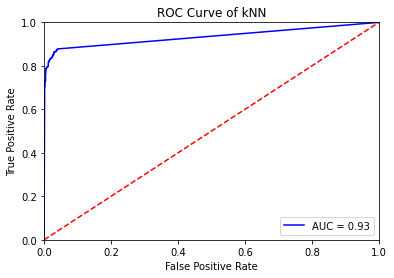

In [26]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()